# Model evaluation

In this notebook, I will compare the accuracy metrics of models

In [33]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [35]:
import scienceplots  # noqa # pylint: disable=unused-import

plt.style.use(["science", "ieee", "default"])
plt.rcParams.update({"axes.grid": True})

In [36]:
from tqdm.auto import tqdm

## Prepare dataloader

In [37]:
from pathlib import Path

ROOT_DATA_DIR = Path("../data/")

In [72]:
from collections import defaultdict

import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

from src.utils import get_metrics

def seed_init_fn(seed=1):
    import numpy as np
    import random
    import torch
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [73]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x_batch, y_batch) in enumerate(dataloader):
        y_pred = model(x_batch)
        
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return res_dict


def test_loop(dataloader, model, loss_fn):
    res_dict = {}
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            y_pred = model(x_batch)
            test_loss += loss_fn(y_pred, y_batch).item()
            all_y.append(y_batch)

            # convert sigmoid to labels
            y_pred = y_pred.reshape(-1)
            y_pred = (y_pred > 0.5).int()
            all_y_pred.append(y_pred)

    test_loss /= num_batches
    res_dict['loss'] = test_loss
    all_y = torch.cat(all_y)
    all_y_pred = torch.cat(all_y_pred)
    res_dict = res_dict | get_metrics(y_true=all_y, y_pred=all_y_pred)
    return res_dict

In [74]:
window_size = 8
train_proportion = 0.9
batch_size = 16
learning_rate = 1e-3
epochs = 50

take only 1 dataset, 1 concrete time series for now...

In [75]:
DATA_DIR = ROOT_DATA_DIR / "KPI-Anomaly-Detection/Preliminary_dataset"

In [76]:
df = pd.read_parquet(DATA_DIR / "train.parquet")
df.rename(columns={'label': 'target'}, inplace=True)
df = df[df["KPI ID"] == "02e99bd4f6cfb33f"].copy()
df = df[df.index > 1.49 * 1e9].copy()
df = df.query("timestamp < 1496538120").copy()
df["time"] = df.index - df.index[0]
df["value"] = df["value"].diff()
# df = df.query('stock==1 & day==0 & train==1')
# df.value = df.value.pct_change()
df.dropna(inplace=True)

In [77]:
# def convert_to_windows(x, window_size):
#     # convert input time series x to
#     # time series of lags, first window_size observations are dropped
#     windows = []
#     for i in range(window_size, len(x)):
#         w = x[i - window_size : i]
#         windows.append(w)
#     windows = np.vstack(windows)
#     return windows

# TODO: maybe make this a general function...
t = df.copy()
# for col in ['value', 'target']:
for col in ['value']:
    for lag in range(0, window_size):
        t[f"lag_{col}_{lag}"] = t[col].shift(lag)
t = t.dropna()
tr_cols = [c for c in t.columns if "lag" in c]
# remove target from train columns
try:
    tr_cols.pop(tr_cols.index('lag_target_0'))
except:
    pass
df = t

In [78]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.plot(df.value.diff())
# plt.subplot(1, 2, 2)
# plt.hist(df.value)
# plt.yscale("log")
# plt.tight_layout();

In [79]:
x = df[tr_cols].values.copy()
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
# x_scaled = x
# x = convert_to_windows(x, window_size)
y = df["target"].values

# class_weights = compute_class_weight('balanced', classes=[0, 1], y=y.ravel())
# class_weights = class_weights / class_weights.sum()

x = torch.Tensor(x)
y = torch.Tensor(y)

train_idx = int(len(x) * train_proportion)
# train_idx = int(1.495 * 1e9)

tr, va = x[:train_idx], x[train_idx:]
# x = np.hstack([x, y.reshape(-1, 1)])
y = y.reshape(-1, 1)
ytr, yva = y[:train_idx], y[train_idx:]
tr_dataset = TensorDataset(tr, ytr)
va_dataset = TensorDataset(va, yva)

# weights = torch.where(ytr.ravel() == 0, class_weights[0], class_weights[1])

# TODO: maybe add test dataset

# debug print
# print(ytr.mean(), yva.mean())

In [80]:
seed_init_fn(1)

# TODO: sampling might be useful for some datasets
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))  
# tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False, sampler=sampler)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=True)

In [81]:
from src.transformer import MultiheadAttention, Transformer

input_dim = len(tr_cols)
embed_dim = 20
num_heads = 4

model = Transformer(input_dim, embed_dim, num_heads, output_dim=1)

In [82]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
seed_init_fn(1)

res_dict = {}
res_dict["tr_metrics"] = []
res_dict["va_metrics"] = []
verbose = False
for t in tqdm(range(epochs)):
    _ = train_loop(
        dataloader=tr_dl,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
    )
    curr_metrics = test_loop(dataloader=tr_dl, model=model, loss_fn=loss_fn)
    if verbose:
        print('train', curr_metrics)
    res_dict["tr_metrics"].append(curr_metrics)
    curr_metrics = test_loop(dataloader=va_dl, model=model, loss_fn=loss_fn)
    if verbose:
        print('val', curr_metrics)
    res_dict["va_metrics"].append(curr_metrics)
    
res_dict['tr_metrics'] = pd.DataFrame(res_dict['tr_metrics'])
res_dict['va_metrics'] = pd.DataFrame(res_dict['va_metrics'])

  0%|          | 0/50 [00:00<?, ?it/s]

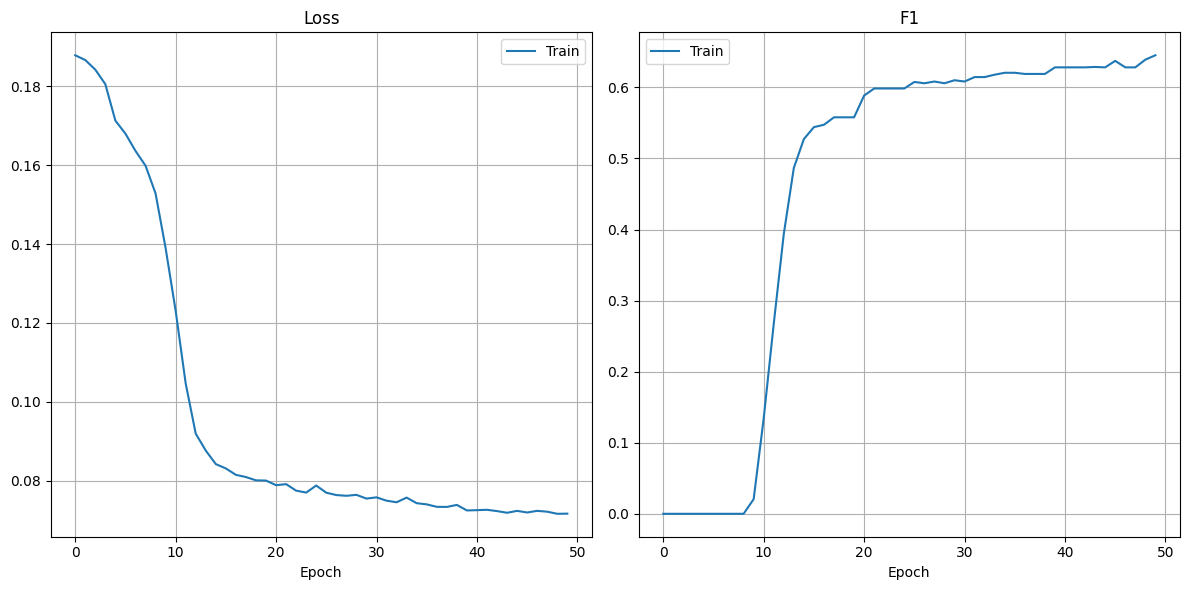

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plt.sca(axs[0])
plt.plot(res_dict["tr_metrics"]['loss'], label='Train')
# plt.plot(res_dict["va_metrics"]['loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.sca(axs[1])
plt.plot(res_dict["tr_metrics"]['f1'], label='Train')
# plt.plot(res_dict["va_metrics"]['f1'], label='Validation')
plt.title('F1')
plt.xlabel('Epoch')
plt.legend()
fig.tight_layout();